In [17]:
import unittest
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [4]:
# Establecer semillas para reproducibilidad
np.random.seed(42)
torch.manual_seed(42)

In [5]:
# Verificar si hay GPU disponible y establecer el dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
# Cargar el dataset
file_path = 'C:/Users/Ana Sofía Cantillo/Documents/Simulacion-Iris/housepricedata.csv'
data = pd.read_csv(file_path)

In [7]:
# Verificar que no hay valores nulos
if data.isnull().values.any():
    raise ValueError("El dataset contiene valores nulos. Por favor, límpialos antes de continuar.")

In [8]:
# Mostrar las primeras filas del dataset para verificar la carga correcta
print("Primeras filas del dataset:\n", data.head())

Primeras filas del dataset:
    LotArea  OverallQual  OverallCond  TotalBsmtSF  FullBath  HalfBath  \
0     8450            7            5          856         2         1   
1     9600            6            8         1262         2         0   
2    11250            7            5          920         2         1   
3     9550            7            5          756         1         0   
4    14260            8            5         1145         2         1   

   BedroomAbvGr  TotRmsAbvGrd  Fireplaces  GarageArea  AboveMedianPrice  
0             3             8           0         548                 1  
1             3             6           1         460                 1  
2             3             6           1         608                 1  
3             3             7           1         642                 0  
4             4             9           1         836                 1  


In [9]:
# Separar las características y las etiquetas
features = data.drop('AboveMedianPrice', axis=1)
labels = data['AboveMedianPrice']

In [10]:
# Normalizar las características
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [11]:
# Convertir a tensores de PyTorch y mover a dispositivo
features_tensor = torch.tensor(features_scaled, dtype=torch.float32).to(device)
labels_tensor = torch.tensor(labels.values, dtype=torch.float32).unsqueeze(1).to(device)

In [26]:
# Definir la arquitectura de la red neuronal con Dropout y parámetros ajustables
class HousePriceNN(nn.Module):
    def __init__(self, input_size=features_tensor.shape[1], hidden1_size=64, hidden2_size=32, dropout_prob=0.5):
        super(HousePriceNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.fc3 = nn.Linear(hidden2_size, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


In [27]:
# Inicializar el modelo, el criterio y el optimizador
modelo = HousePriceNN().to(device)
criterio = nn.MSELoss()
optimizador = optim.Adam(modelo.parameters(), lr=0.001)

In [28]:
# Función para guardar el modelo
def guardar_modelo(modelo, optimizador, path='house_price_model.pth'):
    torch.save({
        'model_state_dict': modelo.state_dict(),
        'optimizer_state_dict': optimizador.state_dict(),
    }, path)

In [29]:
# Función para cargar el modelo
def cargar_modelo(modelo, optimizador, path='house_price_model.pth'):
    checkpoint = torch.load(path)
    modelo.load_state_dict(checkpoint['model_state_dict'])
    optimizador.load_state_dict(checkpoint['optimizer_state_dict'])


In [31]:
# Definir el proceso de entrenamiento con validación y Early Stopping
def entrenar_modelo(modelo, criterio, optimizador, X_train, y_train, X_val, y_val, num_epochs=100, paciencia=10):
    perdidas_entrenamiento = []
    perdidas_validacion = []
    precisiones = []
    recalls = []
    
    mejor_perdida_val = float('inf')
    epochs_sin_mejorar = 0
    
    for epoch in range(num_epochs):
        modelo.train()
        
        salidas = modelo(X_train)
        perdida = criterio(salidas, y_train)
        
        optimizador.zero_grad()
        perdida.backward()
        optimizador.step()
        
        perdidas_entrenamiento.append(perdida.item())
        
        modelo.eval()
        with torch.no_grad():
            salidas_val = modelo(X_val)
            perdida_val = criterio(salidas_val, y_val)
            perdidas_validacion.append(perdida_val.item())

            # Calcular precisión y recall
            predicciones = (salidas_val > 0.5).float()
            precision = precision_score(y_val.cpu(), predicciones.cpu())
            recall = recall_score(y_val.cpu(), predicciones.cpu())
            precisiones.append(precision)
            recalls.append(recall)
        
        if perdida_val < mejor_perdida_val:
            mejor_perdida_val = perdida_val
            epochs_sin_mejorar = 0
        else:
            epochs_sin_mejorar += 1
        
        if epochs_sin_mejorar == paciencia:
            print(f'Early stopping at epoch {epoch+1}')
            break
        
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {perdida.item():.4f}, Val Loss: {perdida_val.item():.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')
    
    return perdidas_entrenamiento, perdidas_validacion, precisiones, recalls


In [32]:
# Validación cruzada con KFold y diferentes arquitecturas
def validar_cruzado_modelo(clase_modelo, criterio, clase_optimizador, características, etiquetas, n_splits=5, num_epochs=100, paciencia=10):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    resultados_folds = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(características)):
        print(f'Fold {fold+1}/{n_splits}')
        
        X_train, X_val = características[train_idx], características[val_idx]
        y_train, y_val = etiquetas[train_idx], etiquetas[val_idx]
        
        modelo = clase_modelo().to(device)
        optimizador = clase_optimizador(modelo.parameters(), lr=0.001)
        
        perdidas_entrenamiento, perdidas_validacion, precisiones, recalls = entrenar_modelo(
            modelo, criterio, optimizador, X_train, y_train, X_val, y_val, num_epochs, paciencia
        )
        
        resultados_folds.append({
            'perdidas_entrenamiento': perdidas_entrenamiento,
            'perdidas_validacion': perdidas_validacion,
            'precisiones': precisiones,
            'recalls': recalls,
        })
    
    return resultados_folds

In [33]:
# Experimentar con diferentes arquitecturas y parámetros
arquitecturas = [
    {'hidden1_size': 64, 'hidden2_size': 32, 'dropout_prob': 0.5},
    {'hidden1_size': 128, 'hidden2_size': 64, 'dropout_prob': 0.5},
    {'hidden1_size': 128, 'hidden2_size': 32, 'dropout_prob': 0.3},
]

resultados = []
for arch in arquitecturas:
    print(f'Testando arquitectura: {arch}')
    clase_modelo = lambda: HousePriceNN(input_size=features_tensor.shape[1], **arch)
    resultado = validar_cruzado_modelo(clase_modelo, criterio, optim.Adam, features_tensor, labels_tensor, num_epochs=100, paciencia=10)
    resultados.append(resultado)

Testando arquitectura: {'hidden1_size': 64, 'hidden2_size': 32, 'dropout_prob': 0.5}
Fold 1/5
Epoch [10/100], Train Loss: 0.2863, Val Loss: 0.1838, Precision: 0.9184, Recall: 0.3435
Epoch [20/100], Train Loss: 0.2189, Val Loss: 0.1369, Precision: 0.8478, Recall: 0.5954
Epoch [30/100], Train Loss: 0.2055, Val Loss: 0.1234, Precision: 0.9043, Recall: 0.6489
Epoch [40/100], Train Loss: 0.2031, Val Loss: 0.1155, Precision: 0.9300, Recall: 0.7099
Epoch [50/100], Train Loss: 0.1876, Val Loss: 0.1062, Precision: 0.9123, Recall: 0.7939
Epoch [60/100], Train Loss: 0.1630, Val Loss: 0.1003, Precision: 0.9068, Recall: 0.8168
Epoch [70/100], Train Loss: 0.1677, Val Loss: 0.0967, Precision: 0.9091, Recall: 0.8397
Epoch [80/100], Train Loss: 0.1550, Val Loss: 0.0933, Precision: 0.9008, Recall: 0.8321
Epoch [90/100], Train Loss: 0.1506, Val Loss: 0.0878, Precision: 0.9032, Recall: 0.8550
Epoch [100/100], Train Loss: 0.1386, Val Loss: 0.0853, Precision: 0.9032, Recall: 0.8550
Fold 2/5
Epoch [10/100], 

c:\Users\Ana Sofía Cantillo\Documents\Simulacion-Iris\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ana Sofía Cantillo\Documents\Simulacion-Iris\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ana Sofía Cantillo\Documents\Simulacion-Iris\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

Epoch [20/100], Train Loss: 0.2692, Val Loss: 0.1846, Precision: 0.9508, Recall: 0.3867
Epoch [30/100], Train Loss: 0.2349, Val Loss: 0.1460, Precision: 0.9479, Recall: 0.6067
Epoch [40/100], Train Loss: 0.2132, Val Loss: 0.1346, Precision: 0.9600, Recall: 0.6400
Epoch [50/100], Train Loss: 0.1830, Val Loss: 0.1189, Precision: 0.9643, Recall: 0.7200
Epoch [60/100], Train Loss: 0.1807, Val Loss: 0.1101, Precision: 0.9675, Recall: 0.7933
Epoch [70/100], Train Loss: 0.1743, Val Loss: 0.1079, Precision: 0.9677, Recall: 0.8000
Epoch [80/100], Train Loss: 0.1670, Val Loss: 0.1006, Precision: 0.9690, Recall: 0.8333
Epoch [90/100], Train Loss: 0.1620, Val Loss: 0.0961, Precision: 0.9695, Recall: 0.8467
Epoch [100/100], Train Loss: 0.1420, Val Loss: 0.0942, Precision: 0.9695, Recall: 0.8467
Fold 3/5


c:\Users\Ana Sofía Cantillo\Documents\Simulacion-Iris\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ana Sofía Cantillo\Documents\Simulacion-Iris\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ana Sofía Cantillo\Documents\Simulacion-Iris\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

Epoch [10/100], Train Loss: 0.4062, Val Loss: 0.4110, Precision: 0.8000, Recall: 0.0248
Epoch [20/100], Train Loss: 0.2624, Val Loss: 0.2573, Precision: 0.8085, Recall: 0.2360
Epoch [30/100], Train Loss: 0.2201, Val Loss: 0.2074, Precision: 0.8770, Recall: 0.6646
Epoch [40/100], Train Loss: 0.2035, Val Loss: 0.1961, Precision: 0.8772, Recall: 0.6211
Epoch [50/100], Train Loss: 0.1867, Val Loss: 0.1883, Precision: 0.8879, Recall: 0.5901
Epoch [60/100], Train Loss: 0.1677, Val Loss: 0.1737, Precision: 0.8939, Recall: 0.7329
Epoch [70/100], Train Loss: 0.1540, Val Loss: 0.1630, Precision: 0.8936, Recall: 0.7826
Epoch [80/100], Train Loss: 0.1668, Val Loss: 0.1564, Precision: 0.9014, Recall: 0.7950
Epoch [90/100], Train Loss: 0.1650, Val Loss: 0.1521, Precision: 0.9085, Recall: 0.8012
Epoch [100/100], Train Loss: 0.1572, Val Loss: 0.1463, Precision: 0.9103, Recall: 0.8199
Fold 4/5
Epoch [10/100], Train Loss: 0.2802, Val Loss: 0.2095, Precision: 0.9444, Recall: 0.2429
Epoch [20/100], Train 

c:\Users\Ana Sofía Cantillo\Documents\Simulacion-Iris\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ana Sofía Cantillo\Documents\Simulacion-Iris\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [30/100], Train Loss: 0.1814, Val Loss: 0.1236, Precision: 0.9043, Recall: 0.7429
Epoch [40/100], Train Loss: 0.1713, Val Loss: 0.1159, Precision: 0.9252, Recall: 0.7071
Epoch [50/100], Train Loss: 0.1671, Val Loss: 0.1079, Precision: 0.9130, Recall: 0.7500
Epoch [60/100], Train Loss: 0.1571, Val Loss: 0.1033, Precision: 0.9153, Recall: 0.7714
Epoch [70/100], Train Loss: 0.1443, Val Loss: 0.1038, Precision: 0.9217, Recall: 0.7571
Early stopping at epoch 72
Fold 5/5
Epoch [10/100], Train Loss: 0.2709, Val Loss: 0.2163, Precision: 0.8070, Recall: 0.3151


c:\Users\Ana Sofía Cantillo\Documents\Simulacion-Iris\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ana Sofía Cantillo\Documents\Simulacion-Iris\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [20/100], Train Loss: 0.2299, Val Loss: 0.1612, Precision: 0.8704, Recall: 0.6438
Epoch [30/100], Train Loss: 0.1865, Val Loss: 0.1426, Precision: 0.9065, Recall: 0.6644
Epoch [40/100], Train Loss: 0.1664, Val Loss: 0.1303, Precision: 0.9091, Recall: 0.7534
Epoch [50/100], Train Loss: 0.1476, Val Loss: 0.1198, Precision: 0.8947, Recall: 0.8151
Epoch [60/100], Train Loss: 0.1448, Val Loss: 0.1141, Precision: 0.9160, Recall: 0.8219
Epoch [70/100], Train Loss: 0.1465, Val Loss: 0.1100, Precision: 0.9242, Recall: 0.8356
Epoch [80/100], Train Loss: 0.1296, Val Loss: 0.1071, Precision: 0.9248, Recall: 0.8425
Epoch [90/100], Train Loss: 0.1293, Val Loss: 0.1034, Precision: 0.9254, Recall: 0.8493
Epoch [100/100], Train Loss: 0.1288, Val Loss: 0.1018, Precision: 0.9323, Recall: 0.8493
Testando arquitectura: {'hidden1_size': 128, 'hidden2_size': 64, 'dropout_prob': 0.5}
Fold 1/5


c:\Users\Ana Sofía Cantillo\Documents\Simulacion-Iris\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ana Sofía Cantillo\Documents\Simulacion-Iris\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [10/100], Train Loss: 0.2225, Val Loss: 0.1413, Precision: 0.8433, Recall: 0.8626
Epoch [20/100], Train Loss: 0.1654, Val Loss: 0.1007, Precision: 0.8976, Recall: 0.8702
Epoch [30/100], Train Loss: 0.1502, Val Loss: 0.0967, Precision: 0.9237, Recall: 0.8321
Epoch [40/100], Train Loss: 0.1424, Val Loss: 0.0915, Precision: 0.8906, Recall: 0.8702
Epoch [50/100], Train Loss: 0.1342, Val Loss: 0.0882, Precision: 0.8906, Recall: 0.8702
Epoch [60/100], Train Loss: 0.1298, Val Loss: 0.0834, Precision: 0.9040, Recall: 0.8626
Epoch [70/100], Train Loss: 0.1177, Val Loss: 0.0788, Precision: 0.8968, Recall: 0.8626
Epoch [80/100], Train Loss: 0.1184, Val Loss: 0.0772, Precision: 0.9040, Recall: 0.8626
Epoch [90/100], Train Loss: 0.1110, Val Loss: 0.0752, Precision: 0.8968, Recall: 0.8626
Epoch [100/100], Train Loss: 0.1077, Val Loss: 0.0735, Precision: 0.9200, Recall: 0.8779
Fold 2/5


c:\Users\Ana Sofía Cantillo\Documents\Simulacion-Iris\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ana Sofía Cantillo\Documents\Simulacion-Iris\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ana Sofía Cantillo\Documents\Simulacion-Iris\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

Epoch [10/100], Train Loss: 0.2345, Val Loss: 0.1792, Precision: 0.8500, Recall: 0.6800
Epoch [20/100], Train Loss: 0.1725, Val Loss: 0.1199, Precision: 0.9492, Recall: 0.7467
Epoch [30/100], Train Loss: 0.1644, Val Loss: 0.1111, Precision: 0.9754, Recall: 0.7933
Epoch [40/100], Train Loss: 0.1414, Val Loss: 0.0983, Precision: 0.9552, Recall: 0.8533
Epoch [50/100], Train Loss: 0.1346, Val Loss: 0.0955, Precision: 0.9624, Recall: 0.8533
Epoch [60/100], Train Loss: 0.1336, Val Loss: 0.0894, Precision: 0.9489, Recall: 0.8667
Epoch [70/100], Train Loss: 0.1193, Val Loss: 0.0855, Precision: 0.9496, Recall: 0.8800
Epoch [80/100], Train Loss: 0.1247, Val Loss: 0.0826, Precision: 0.9500, Recall: 0.8867
Epoch [90/100], Train Loss: 0.1251, Val Loss: 0.0825, Precision: 0.9568, Recall: 0.8867
Epoch [100/100], Train Loss: 0.1128, Val Loss: 0.0769, Precision: 0.9504, Recall: 0.8933
Fold 3/5
Epoch [10/100], Train Loss: 0.2267, Val Loss: 0.2181, Precision: 0.8972, Recall: 0.5963
Epoch [20/100], Train 

c:\Users\Ana Sofía Cantillo\Documents\Simulacion-Iris\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ana Sofía Cantillo\Documents\Simulacion-Iris\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ana Sofía Cantillo\Documents\Simulacion-Iris\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

Epoch [10/100], Train Loss: 0.3266, Val Loss: 0.2819, Precision: 0.8182, Recall: 0.1800
Epoch [20/100], Train Loss: 0.2426, Val Loss: 0.1637, Precision: 0.8684, Recall: 0.6600
Epoch [30/100], Train Loss: 0.1847, Val Loss: 0.1382, Precision: 0.9273, Recall: 0.6800
Epoch [40/100], Train Loss: 0.1732, Val Loss: 0.1262, Precision: 0.9474, Recall: 0.7200
Epoch [50/100], Train Loss: 0.1543, Val Loss: 0.1126, Precision: 0.9173, Recall: 0.8133
Epoch [60/100], Train Loss: 0.1438, Val Loss: 0.1067, Precision: 0.9323, Recall: 0.8267
Epoch [70/100], Train Loss: 0.1360, Val Loss: 0.0986, Precision: 0.9338, Recall: 0.8467
Epoch [80/100], Train Loss: 0.1267, Val Loss: 0.0918, Precision: 0.9155, Recall: 0.8667
Epoch [90/100], Train Loss: 0.1156, Val Loss: 0.0875, Precision: 0.9231, Recall: 0.8800
Epoch [100/100], Train Loss: 0.1139, Val Loss: 0.0829, Precision: 0.9178, Recall: 0.8933
Fold 3/5
Epoch [10/100], Train Loss: 0.4342, Val Loss: 0.4487, Precision: 0.4000, Recall: 0.0248


c:\Users\Ana Sofía Cantillo\Documents\Simulacion-Iris\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ana Sofía Cantillo\Documents\Simulacion-Iris\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ana Sofía Cantillo\Documents\Simulacion-Iris\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

Epoch [20/100], Train Loss: 0.2521, Val Loss: 0.2878, Precision: 0.7361, Recall: 0.3292
Epoch [30/100], Train Loss: 0.1858, Val Loss: 0.2472, Precision: 0.8923, Recall: 0.7205
Epoch [40/100], Train Loss: 0.1563, Val Loss: 0.2213, Precision: 0.8926, Recall: 0.6708
Epoch [50/100], Train Loss: 0.1459, Val Loss: 0.1975, Precision: 0.9194, Recall: 0.7081
Epoch [60/100], Train Loss: 0.1377, Val Loss: 0.1751, Precision: 0.9143, Recall: 0.7950
Epoch [70/100], Train Loss: 0.1301, Val Loss: 0.1599, Precision: 0.9028, Recall: 0.8075
Epoch [80/100], Train Loss: 0.1273, Val Loss: 0.1511, Precision: 0.8973, Recall: 0.8137
Epoch [90/100], Train Loss: 0.1191, Val Loss: 0.1450, Precision: 0.8986, Recall: 0.8261
Epoch [100/100], Train Loss: 0.1202, Val Loss: 0.1400, Precision: 0.9013, Recall: 0.8509
Fold 4/5
Epoch [10/100], Train Loss: 0.2118, Val Loss: 0.2049, Precision: 0.8866, Recall: 0.6143
Epoch [20/100], Train Loss: 0.1689, Val Loss: 0.1430, Precision: 0.8917, Recall: 0.7643
Epoch [30/100], Train 

c:\Users\Ana Sofía Cantillo\Documents\Simulacion-Iris\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ana Sofía Cantillo\Documents\Simulacion-Iris\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [10/100], Train Loss: 0.2082, Val Loss: 0.1843, Precision: 0.8243, Recall: 0.4178
Epoch [20/100], Train Loss: 0.1532, Val Loss: 0.1277, Precision: 0.8440, Recall: 0.8151
Epoch [30/100], Train Loss: 0.1417, Val Loss: 0.1149, Precision: 0.8741, Recall: 0.8562
Epoch [40/100], Train Loss: 0.1246, Val Loss: 0.1115, Precision: 0.8690, Recall: 0.8630
Epoch [50/100], Train Loss: 0.1114, Val Loss: 0.1036, Precision: 0.8467, Recall: 0.8699
Epoch [60/100], Train Loss: 0.1116, Val Loss: 0.0970, Precision: 0.8819, Recall: 0.8699
Epoch [70/100], Train Loss: 0.1049, Val Loss: 0.0931, Precision: 0.8828, Recall: 0.8767
Epoch [80/100], Train Loss: 0.0995, Val Loss: 0.0890, Precision: 0.8767, Recall: 0.8767
Epoch [90/100], Train Loss: 0.0973, Val Loss: 0.0838, Precision: 0.8897, Recall: 0.8836
Epoch [100/100], Train Loss: 0.0958, Val Loss: 0.0815, Precision: 0.8951, Recall: 0.8767


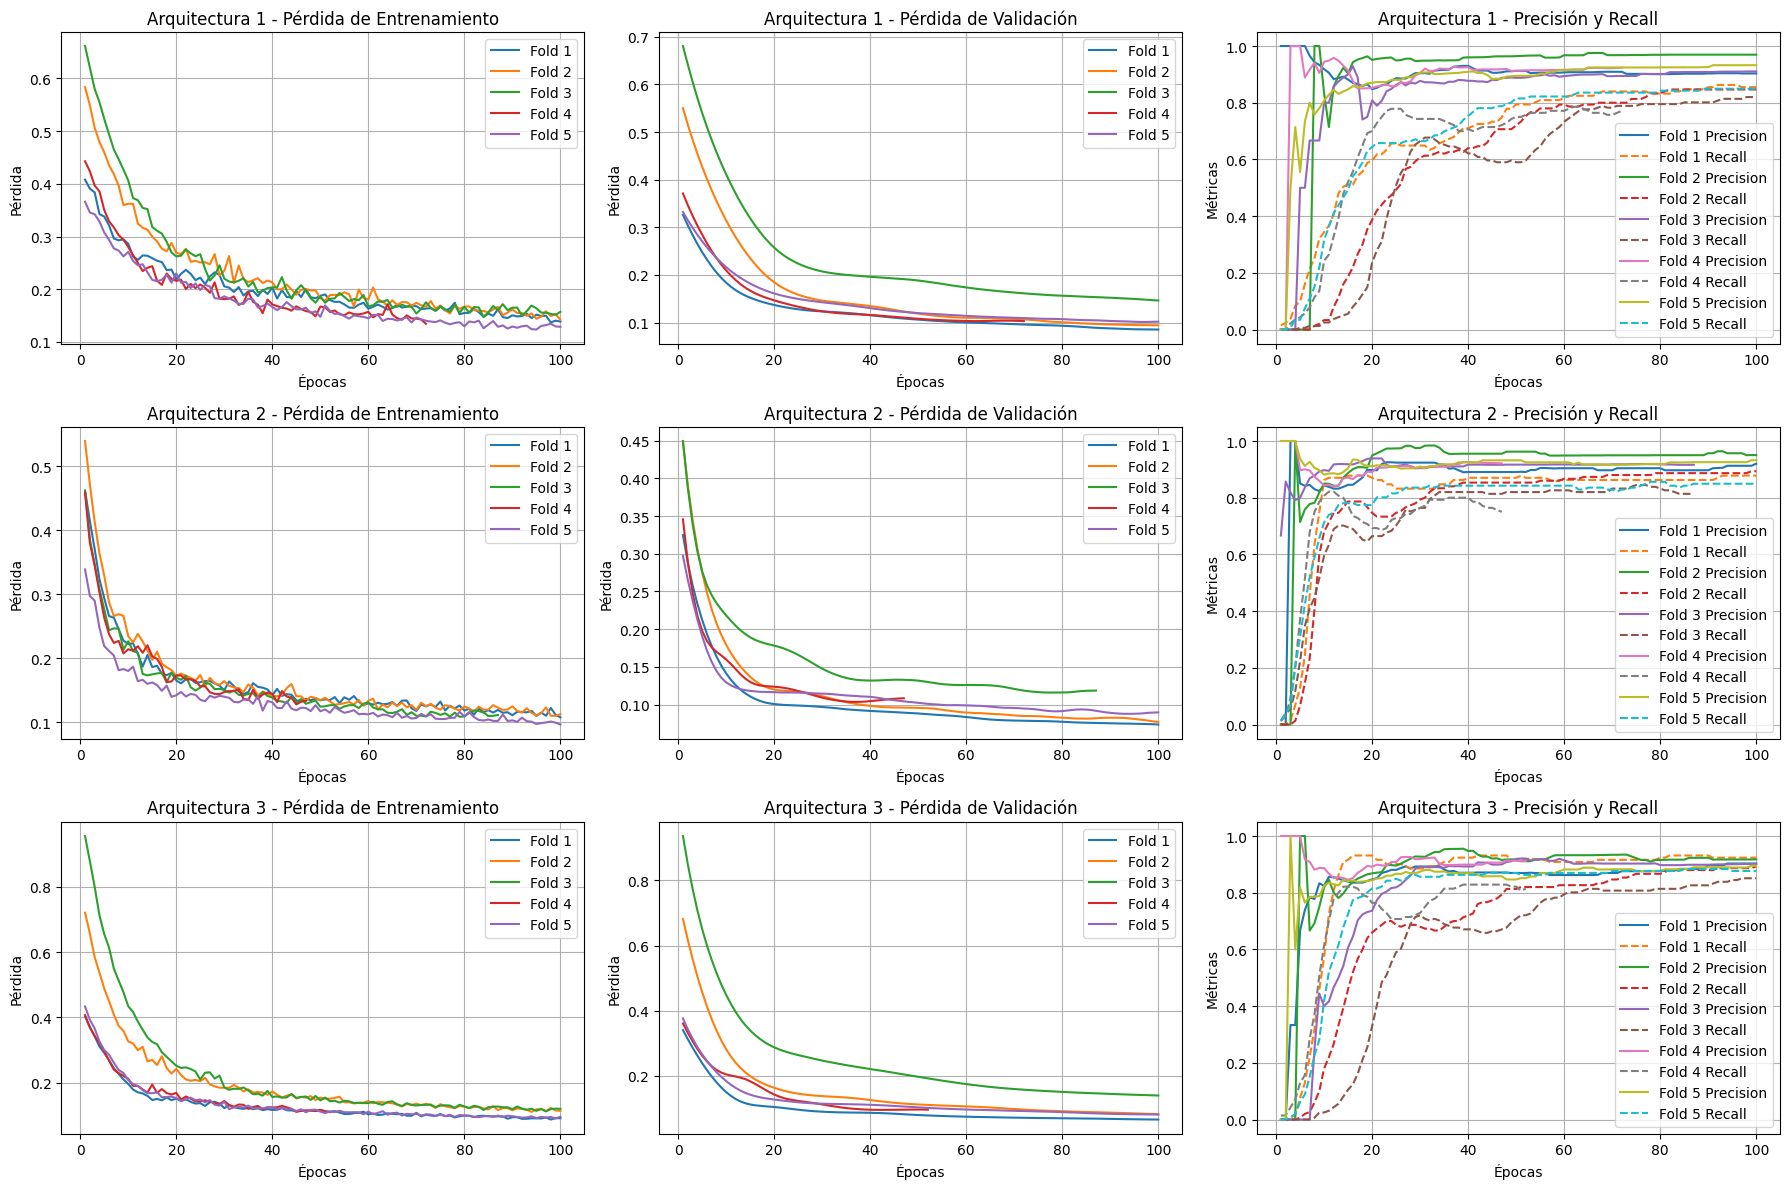

In [34]:
# Graficar las pérdidas y las métricas adicionales para la validación cruzada
fig, axes = plt.subplots(len(resultados), 3, figsize=(18, 12))

for arch_idx, resultado in enumerate(resultados):
    for fold_idx, fold_result in enumerate(resultado):
        rango_epocas = range(1, len(fold_result['perdidas_entrenamiento']) + 1)

        axes[arch_idx, 0].plot(rango_epocas, fold_result['perdidas_entrenamiento'], label=f'Fold {fold_idx+1}')
        axes[arch_idx, 1].plot(rango_epocas, fold_result['perdidas_validacion'], label=f'Fold {fold_idx+1}')
        axes[arch_idx, 2].plot(rango_epocas, fold_result['precisiones'], label=f'Fold {fold_idx+1} Precision')
        axes[arch_idx, 2].plot(rango_epocas, fold_result['recalls'], label=f'Fold {fold_idx+1} Recall', linestyle='--')

for arch_idx, ax in enumerate(axes):
    ax[0].set_title(f'Arquitectura {arch_idx+1} - Pérdida de Entrenamiento')
    ax[0].set_xlabel('Épocas')
    ax[0].set_ylabel('Pérdida')
    ax[0].legend()
    ax[0].grid(True)
    
    ax[1].set_title(f'Arquitectura {arch_idx+1} - Pérdida de Validación')
    ax[1].set_xlabel('Épocas')
    ax[1].set_ylabel('Pérdida')
    ax[1].legend()
    ax[1].grid(True)
    
    ax[2].set_title(f'Arquitectura {arch_idx+1} - Precisión y Recall')
    ax[2].set_xlabel('Épocas')
    ax[2].set_ylabel('Métricas')
    ax[2].legend()
    ax[2].grid(True)

plt.tight_layout()
plt.show()


In [35]:
# Implementación de pruebas unitarias
class TestHousePriceNN(unittest.TestCase):
    def setUp(self):
        self.modelo = HousePriceNN().to(device)
        self.criterio = nn.MSELoss()
        self.optimizador = optim.Adam(self.modelo.parameters(), lr=0.001)
        
        # Generar datos de prueba
        self.X_train_tensor = features_tensor[:100]
        self.y_train_tensor = labels_tensor[:100]
        self.X_val_tensor = features_tensor[100:150]
        self.y_val_tensor = labels_tensor[100:150]

    def test_inicializacion(self):
        # Verificar si la red neuronal se inicializa correctamente
        self.assertEqual(self.modelo.fc1.in_features, features_tensor.shape[1])
        self.assertEqual(self.modelo.fc1.out_features, 64)
        self.assertEqual(self.modelo.fc2.in_features, 64)
        self.assertEqual(self.modelo.fc2.out_features, 32)
        self.assertEqual(self.modelo.fc3.in_features, 32)
        self.assertEqual(self.modelo.fc3.out_features, 1)

    def test_paso_adelante(self):
        # Verificar si la salida tiene la forma correcta
        salida = self.modelo(self.X_train_tensor)
        self.assertEqual(salida.shape, (self.X_train_tensor.shape[0], 1))

    def test_paso_entrenamiento(self):
        # Realizar varias pasadas de entrenamiento y verificar si la pérdida se reduce
        perdida_inicial = self.criterio(self.modelo(self.X_train_tensor), self.y_train_tensor).item()
        for _ in range(10):
            self.optimizador.zero_grad()
            perdida = self.criterio(self.modelo(self.X_train_tensor), self.y_train_tensor)
            perdida.backward()
            self.optimizador.step()
        nueva_perdida = self.criterio(self.modelo(self.X_train_tensor), self.y_train_tensor).item()
        self.assertLess(nueva_perdida, perdida_inicial)

    def test_paso_validacion(self):
        # Verificar la precisión en el conjunto de validación
        self.modelo.eval()
        with torch.no_grad():
            salida_val = self.modelo(self.X_val_tensor)
            perdida_val = self.criterio(salida_val, self.y_val_tensor).item()
            mae = torch.mean(torch.abs(salida_val - self.y_val_tensor)).item()
            mse = torch.mean((salida_val - self.y_val_tensor) ** 2).item()
        
        # Asegurarse de que las métricas son valores razonables
        self.assertGreaterEqual(mae, 0.0)
        self.assertGreaterEqual(mse, 0.0)

    def test_guardar_y_cargar_modelo(self):
        # Guardar y cargar el modelo, y verificar que los estados del modelo son idénticos
        ruta_guardar_modelo = 'test_house_price_model.pth'
        guardar_modelo(self.modelo, self.optimizador, ruta_guardar_modelo)
        
        nuevo_modelo = HousePriceNN().to(device)
        nuevo_optimizador = optim.Adam(nuevo_modelo.parameters(), lr=0.001)
        cargar_modelo(nuevo_modelo, nuevo_optimizador, ruta_guardar_modelo)
        
        for param_original, param_cargado in zip(self.modelo.parameters(), nuevo_modelo.parameters()):
            self.assertTrue(torch.equal(param_original, param_cargado))


In [37]:
# Ejecutar las pruebas unitarias
if __name__ == '_main_':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)